Import all necessary Libraries

In [ ]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
%config InlineBackend.figure_format = 'retina'

Basic hyperparameters

In [ ]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 128
N_EPOCHS = 15

IMG_SIZE = 28
N_CLASSES = 10

# Data

In [ ]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((28, 28)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    correct_pred = 0
    n = 0

    # Do all operations in evaluation mode with gradient calculation and accumulation disabled

    with torch.no_grad():
      model.eval()
      for X, y_true in data_loader:

          X = X.to(device)
          y_true = y_true.to(device)

          _, y_prob = model(X)
          _, predicted_labels = torch.max(y_prob, 1)

          n += y_true.size(0)
          correct_pred += (predicted_labels == y_true).sum()


    return correct_pred.float() / n

def plot_accuracy_losses(train_losses, valid_losses, train_accuracy, valid_accuracy):
    '''
    Function for plotting training and validation losses and accuracy
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()

    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_accuracy, color='blue', label='Training accuracy')
    ax.plot(valid_accuracy, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
            xlabel='Epoch',
            ylabel='Accuracy')
    ax.legend()
    fig.show()


    # change the plot style to default
    plt.style.use('default')


def train_validate(data_loader, model,  criterion, optimizer, device, train):
    '''
    Function for the training/validation step of the training loop
    '''

    '''
    Select model mode
    '''
    if train == 1:
      model.train()
    else:
      model.eval()

    running_loss = 0

    for X, y_true in data_loader:

        '''
        Reset gradient values to 0 before starting of each batch.
        '''
        if train == 1:
          optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)


        if train == 1:
          # Backward pass only valid while training, not while validating/testing

          # print(model.training)
          # print(loss.requires_grad,y_hat.requires_grad)
          loss.backward()
          optimizer.step()


    epoch_loss = running_loss / len(data_loader.dataset)
    return model, optimizer, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_validate(train_loader, model, criterion, optimizer,device,train=1)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, _,valid_loss = train_validate(valid_loader, model, criterion, optimizer, device,train=0)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            train_accuracy.append(train_acc)
            valid_accuracy.append(valid_acc)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_accuracy_losses(train_losses, valid_losses, train_accuracy,valid_accuracy)

    return model, optimizer, (train_losses, valid_losses)

**Plotting the images from the dataset**

In [ ]:
ROW_IMG = 10
N_ROWS = 5

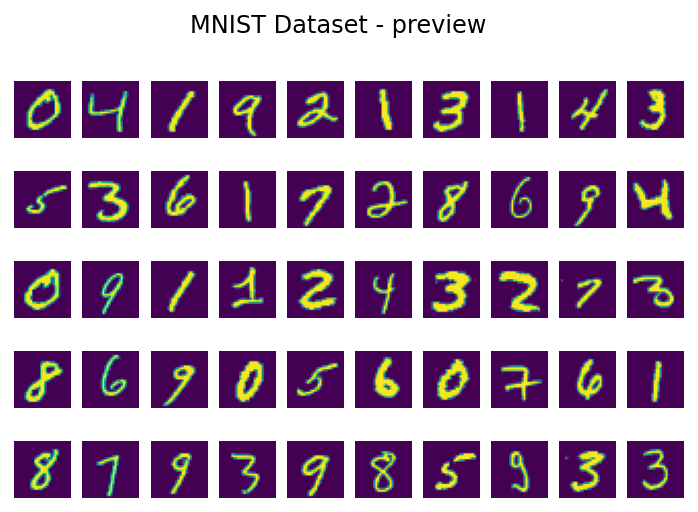

In [ ]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()


        '''
        out1 and out2 will be used for storing/accessing activations
        in1 and in2 will be used storing/accessing maxima locations in various pooling regions
        '''
        self.out1, self.in1 = None, None
        self.out2, self.in2 = None, None


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)

        self.classifier = nn.Sequential(
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x, self.in1 = self.pool(F.relu(self.conv1(x)))
        self.out1 = x
        x, self.in2 = self.pool(F.relu(self.conv2(x)))
        self.out2 = x
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

13:09:51 --- Epoch: 0	Train loss: 0.3834	Valid loss: 0.1219	Train accuracy: 96.05	Valid accuracy: 96.14
13:10:33 --- Epoch: 1	Train loss: 0.0990	Valid loss: 0.0669	Train accuracy: 97.75	Valid accuracy: 97.83
13:11:17 --- Epoch: 2	Train loss: 0.0692	Valid loss: 0.0489	Train accuracy: 98.51	Valid accuracy: 98.50
13:12:00 --- Epoch: 3	Train loss: 0.0543	Valid loss: 0.0524	Train accuracy: 98.32	Valid accuracy: 98.35
13:12:44 --- Epoch: 4	Train loss: 0.0436	Valid loss: 0.0426	Train accuracy: 98.86	Valid accuracy: 98.58
13:13:30 --- Epoch: 5	Train loss: 0.0368	Valid loss: 0.0494	Train accuracy: 98.66	Valid accuracy: 98.50
13:14:18 --- Epoch: 6	Train loss: 0.0318	Valid loss: 0.0370	Train accuracy: 99.17	Valid accuracy: 98.86
13:15:00 --- Epoch: 7	Train loss: 0.0284	Valid loss: 0.0344	Train accuracy: 99.16	Valid accuracy: 98.90
13:15:43 --- Epoch: 8	Train loss: 0.0247	Valid loss: 0.0262	Train accuracy: 99.52	Valid accuracy: 99.08
13:16:27 --- Epoch: 9	Train loss: 0.0219	Valid loss: 0.0390	Trai

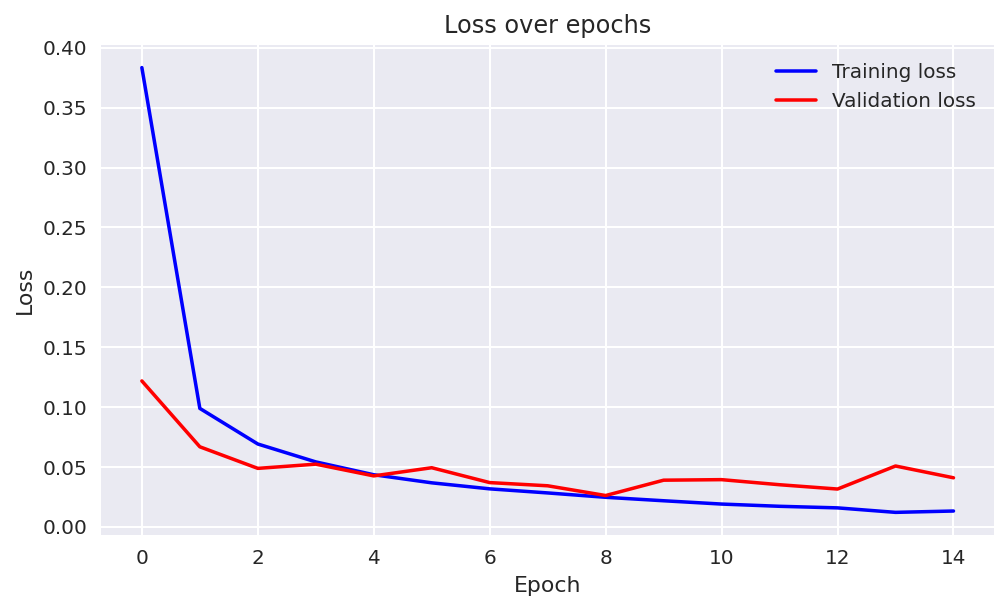

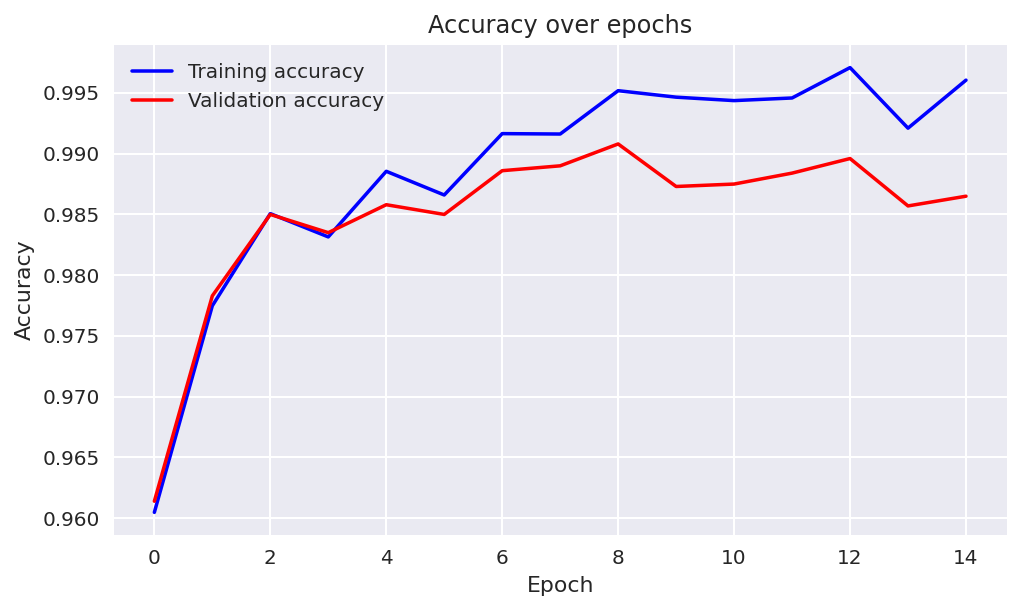

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)


**Evaluating the predictions**

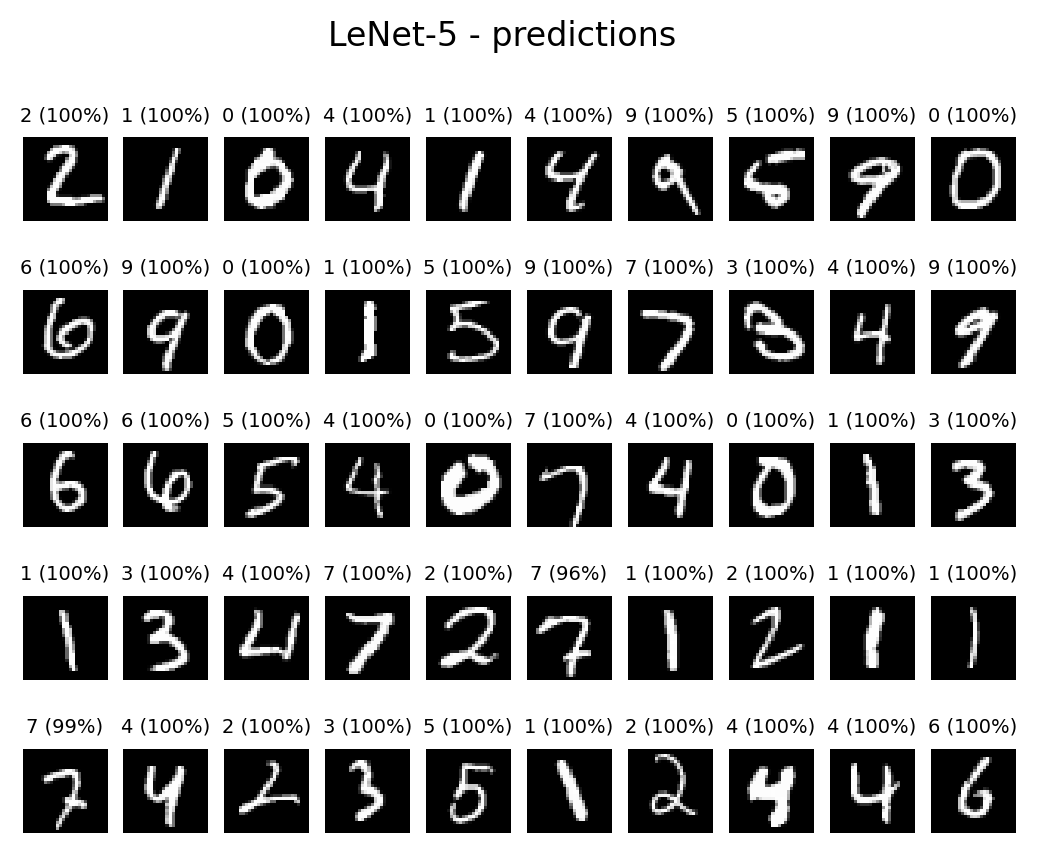

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray')

    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

## Function to transpose the kernels

In [ ]:
def get_transpose(w):
  layer1 = torch.transpose(w,0,1)
  layer1 = torch.transpose(layer1,2,3)
  return layer1

### Analyzing the shapes of transposed kernels

In [ ]:
w2 = model.conv2.weight
w2 = w2.detach()
w1 = model.conv1.weight
w1 = w1.detach()
inv_kernel2 = get_transpose(w2)
inv_kernel1 = get_transpose(w1)

print(w1.shape)
print(w2.shape)

print(inv_kernel2.shape)
print(inv_kernel1.shape)

torch.Size([6, 1, 5, 5])
torch.Size([16, 6, 5, 5])
torch.Size([6, 16, 5, 5])
torch.Size([1, 6, 5, 5])


## Analyze activations in the first layer
Notice in the plots how some kernels are trying to observe foreground, while some others are trying to observe background

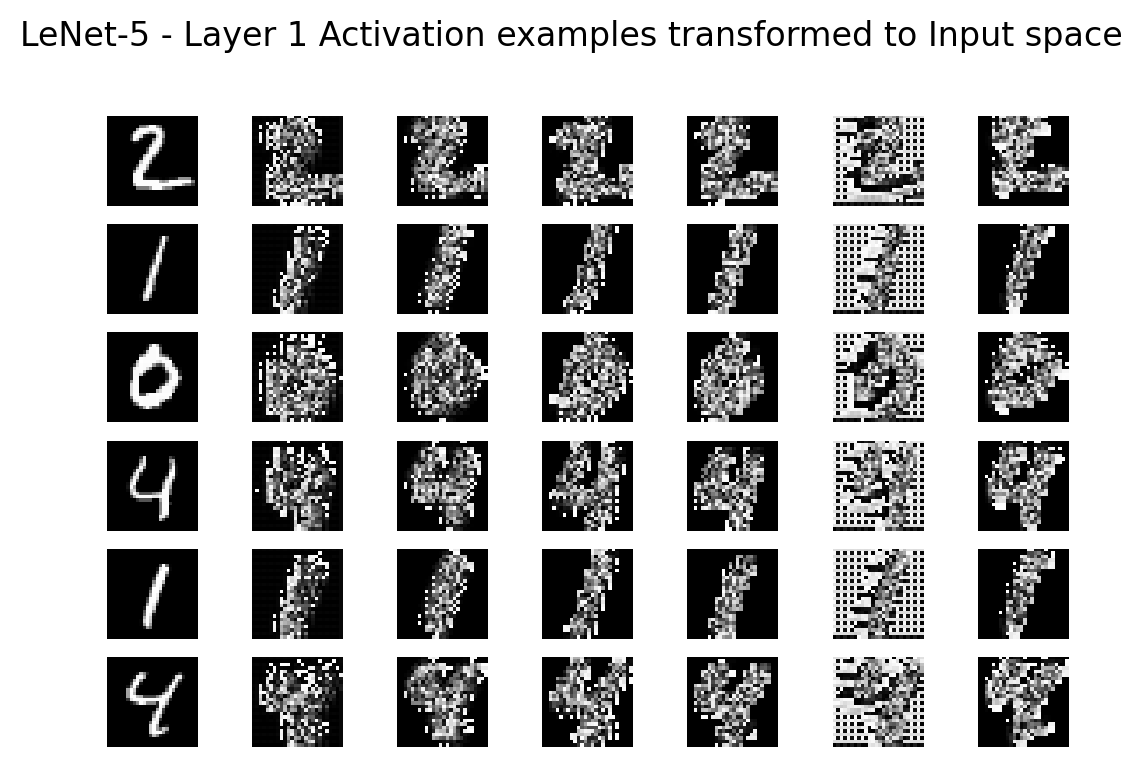

In [ ]:
import torchvision.transforms as T
ROW_IMG = 7
N_ROWS = 7
unpool = nn.MaxUnpool2d(kernel_size=2)
count = 1

plt.close('all')

fig = plt.figure()
for index in range(1, N_ROWS):
    plt.subplot(N_ROWS, ROW_IMG, count)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray')
    count += 1

    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        for i in range(model.out1.shape[1]):
          '''
          Copy all the activations to another tensor to keep the original ones intact even after zeroing
          '''
          out1 = model.out1.clone()

          '''
          Zero out all activations in the layer except the one to be analyzed
          '''
          for j in range(model.out1.shape[1]):
            if i != j:
              out1[0,j] = torch.zeros_like(model.out1[0,0])

          out = F.relu(unpool(out1, model.in1))
          inv_kernel1 = get_transpose(w1)
          out = F.conv2d(out, inv_kernel1, stride=1, padding=1)
          tensor = out.detach()

          plt.subplot(N_ROWS, ROW_IMG, count)
          plt.axis('off')
          plt.imshow(T.ToPILImage()(tensor[0]), cmap='gray')
          count += 1

    # plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - Layer 1 Activation examples transformed to Input space');
plt.show()

### Analyze activations in the second layer

Notice here the activations are confined to certain regions and are trying to learn how to combine smaller structures confined to one region with structures confined to another region.

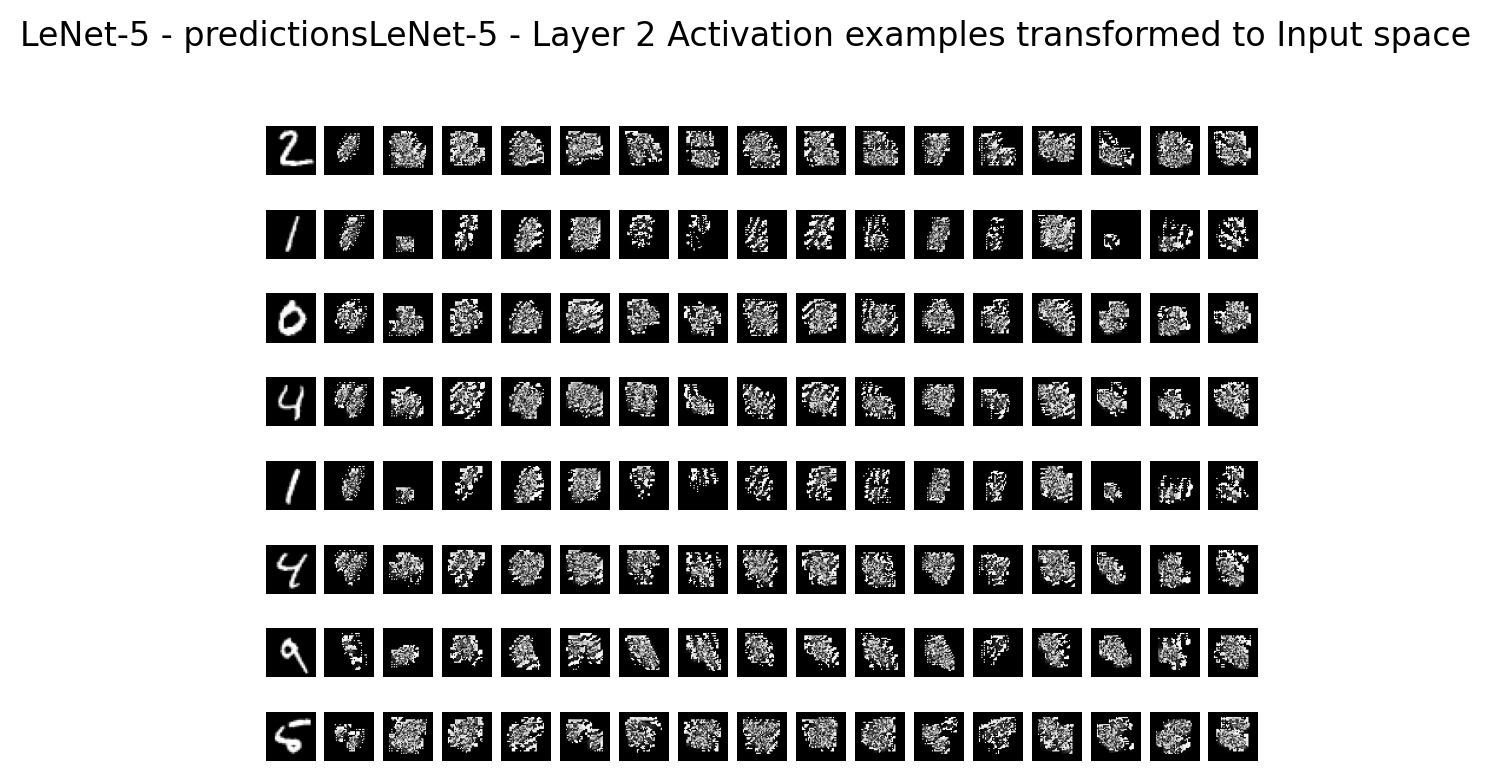

In [ ]:
ROW_IMG = 7
N_ROWS = 15
unpool = nn.MaxUnpool2d(kernel_size=2)
count = 1

fig = plt.figure()
for index in range(1,9):
    plt.subplot(9, model.out2.shape[1]+1, count)
    plt.imshow(valid_dataset.data[index], cmap='gray')

    plt.axis('off')
    count += 1

    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        for i in range(model.out2.shape[1]):

          '''
          Copy all the activations to another tensor to keep the original ones intact even after zeroing
          '''
          out2 = model.out2.clone()

          '''
          Zero out all activations in the layer except the one to be analyzed
          '''
          for j in range(model.out2.shape[1]):
            if i != j:
              out2[0,j] = torch.zeros_like(model.out2[0,0])
          out2 = F.relu(unpool(out2, model.in2))

          inv_kernel2 = get_transpose(w2)
          inv_kernel1 = get_transpose(w1)

          out2 = F.conv2d(out2, inv_kernel2, stride=1, padding=4)

          '''
          Notice that we are not zeroing out activations in this layer
          '''
          out1 = F.relu(unpool(out2, model.in1))
          out = F.conv2d(out1, inv_kernel1, stride=1, padding=9)
          tensor = out.detach()

          plt.subplot(9, model.out2.shape[1]+1, count)
          plt.axis('off')

          plt.imshow(T.ToPILImage()(tensor[0,0]), cmap='gray')
          count += 1

fig.suptitle('LeNet-5 - predictionsLeNet-5 - Layer 2 Activation examples transformed to Input space')
plt.show()

In [ ]:
# remove the downloaded dataset
!rm -r mnist_data